# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size

print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


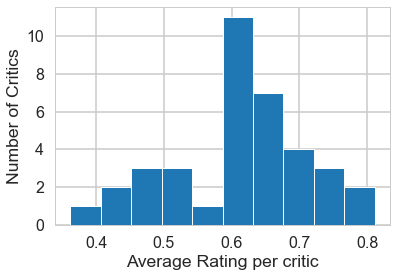

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

<div class="alert alert-success">
<p>
The historgram above takes into consideration the critics who have reviewed more than 100 movies. Since they have given so many reviews we can assume that they are movie buffs and like to critique movies as well. We should also look at data for other critics as well.
<p>
Here most of the critics have given average rating above 0.5. Also, the mean seems to be somewhat greater than 0.6. This might suggest that the movie buffs really like the movies overall and tend to give higher ratings.
<p>
Another explanation is that these people are good at selecting good movies to watch. It is natural that a person who watches a lot of movies can tell by knowing about trailer, storyline, director, actor etc. that a movie will turn out to be good etc. Also people don't just watch any movie, they select movies which they are likely to like.
<p>
Now let us look at some more data including other critics (who have reviewed more than 20 movies). This chart is more normal-ish and the mean is around 0.6. These critics might not be that big lovers of movies and hence we also see lower ratings.
</div>

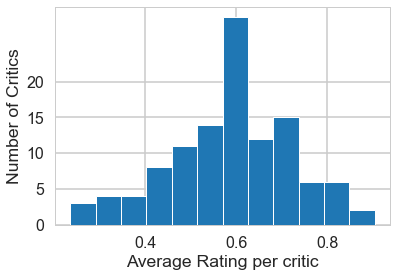

In [5]:
means[counts > 20].hist(bins=12, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 5, 10, 15, 20]);

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)
print(x)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop
  (0, 0)	1
  (0, 2)	1
  (0, 3)	1
  (1, 0)	1
  (1, 1)	1
  (1, 3)	1
  (2, 0)	3

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [7]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    
    return X, y
X, y = make_xy(critics)

In [8]:
X,y

(<15561x22417 sparse matrix of type '<class 'numpy.int64'>'
 	with 272265 stored elements in Compressed Sparse Column format>,
 array([1, 1, 1, ..., 1, 1, 1]))

In [9]:
X.sum()

295413

In [10]:
# total number of words in all the quotes
words_len = [len(str.split(quote," ")) for quote in critics.quote]
np.sum(words_len)

302575

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [11]:
#your turn
from sklearn.metrics import accuracy_score,classification_report,classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X_train,X_test,y_train,y_test = train_test_split(X,y)
X_train.shape, X_test.shape

((11670, 22417), (3891, 22417))

In [13]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
y_pred = mnb.predict(X_test)
print("test accuracy: ",accuracy_score(y_pred=y_pred,y_true=y_test))

test accuracy:  0.7694680030840401


In [15]:
print(classification_report(y_pred=y_pred,y_true=y_test))

             precision    recall  f1-score   support

          0       0.74      0.65      0.69      1540
          1       0.79      0.85      0.82      2351

avg / total       0.77      0.77      0.77      3891



In [16]:
print("train accuracy: ",mnb.score(X=X_train,y=y_train))

train accuracy:  0.9199657240788346


<div class="alert alert-success">
This is not a good classifier because the test accuracy score (0.76) is significantly lesser than train accuracy (0.91). It means the classifier is overfitting the data.
</div>

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [13]:
# Your turn

# copy it, so as not to change original data
critics_df = critics.copy()
critics_df.quote = critics_df.quote.str.lower()
critics_df.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"so ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,the year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,a winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,the film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"an entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [18]:
X_hp,y = make_xy(critics_df)
df_word_f = pd.DataFrame(data=(X_hp.sum(axis=0).transpose()).A[:,0])

# index is the words list and column (NumOfDocs) have the number of docs the index word is present in
df_word_f.columns = ["NumOfDocs"]
df_word_f.index.name = "Word"
print(df_word_f.head(10))
print(df_word_f.shape)

      NumOfDocs
Word           
0             8
1             1
2            10
3             1
4             1
5            39
6            17
7             4
8             1
9             1
(22417, 1)


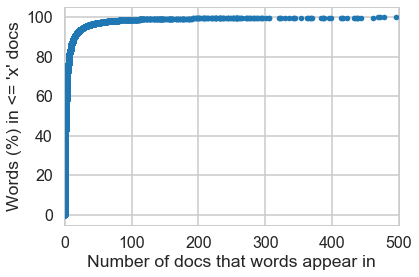

In [19]:
# lets draw cumulative density function
x = np.sort(df_word_f["NumOfDocs"])
y= np.arange(1,len(x)+1)*100/len(x)
plt.plot(x,y,marker='.',linestyle='none')
plt.xlim(-1,500)
plt.xlabel("Number of docs that words appear in")
plt.ylabel("Words (%) in <= 'x' docs")
plt.show()

<div class="alert alert-success">
From the chart above we can see that min_df(point of steep curve) is very close to 0 and max_df(point of start of plateau) close to 100 or 0.006 (=100/15561 when float).
</div>

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [20]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [21]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [22]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

<div class="alert alert-success">
We are trying to maximize the probabilities. For example there might be 2 models that accurately predicts a particular class for a given input data, but we would prefer the model that gave higher probability for that class.

<p>
<p>
α is a hyper-parameter to smoothen the model so that it does not overfit and also to avoid chances of 0 probabilities in calculations. Higher values of α might result in too much smoothening and thus affecting the accuracy of the result. We can empirically find optimum value for α.

</div>

In [23]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
min_dfs = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.005]
best_min_df = None # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df=min_df)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        # your turn
        curr_score = cv_score(MultinomialNB(alpha=alpha),Xtrainthis,ytrainthis,log_likelihood)
        print("score: {} ,alpha: {}, min_df: {}".format(curr_score,alpha,min_df))
        if maxscore <  curr_score:
            maxscore = curr_score
            best_alpha = alpha
            best_min_df = min_df
        

score: -983.1589326329752 ,alpha: 0.1, min_df: 1e-05
score: -983.1589326329752 ,alpha: 0.1, min_df: 3e-05
score: -983.2702137723361 ,alpha: 0.1, min_df: 0.0001
score: -933.2886541934846 ,alpha: 0.1, min_df: 0.0003
score: -714.7887508861971 ,alpha: 0.1, min_df: 0.001
score: -610.8766194532847 ,alpha: 0.1, min_df: 0.003
score: -604.985333383392 ,alpha: 0.1, min_df: 0.005
score: -740.6964906940746 ,alpha: 1, min_df: 1e-05
score: -740.6964906940746 ,alpha: 1, min_df: 3e-05
score: -638.8466928241555 ,alpha: 1, min_df: 0.0001
score: -608.2608213673284 ,alpha: 1, min_df: 0.0003
score: -581.546694742058 ,alpha: 1, min_df: 0.001
score: -587.6104758134856 ,alpha: 1, min_df: 0.003
score: -596.7026024422179 ,alpha: 1, min_df: 0.005
score: -1284.9505605527904 ,alpha: 5, min_df: 1e-05
score: -1284.9505605527904 ,alpha: 5, min_df: 3e-05
score: -1018.6064895229049 ,alpha: 5, min_df: 0.0001
score: -726.351368948376 ,alpha: 5, min_df: 0.0003
score: -557.7748833856315 ,alpha: 5, min_df: 0.001
score: -565

In [24]:
print("best alpha: {}".format(best_alpha))
print("best min_df: {}".format(best_min_df))
print("max score: {}".format(maxscore))

best alpha: 5
best min_df: 0.001
max score: -557.7748833856315


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [25]:
vectorizer = CountVectorizer(min_df=0.003)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.746627
Accuracy on test data:     0.692802


In [26]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2076 2179]
 [1167 5470]]


<div class="alert alert-success">
Yes. The accuracy of this classifier is less. But still it is a better classifier because it doesn't overfit the data as much. We found the best hyper-parameters. And there is less gap in train and test accuracies.
</div>


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [27]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
        entertaining 0.85
         intelligent 0.85
            powerful 0.84
               smart 0.83
         masterpiece 0.83
         performance 0.82
                ever 0.81
           hilarious 0.81
               witty 0.81
            touching 0.81
Bad words	     P(fresh | word)
                  tv 0.31
               lacks 0.31
             obvious 0.31
                 bad 0.31
                 nor 0.31
               fails 0.30
               worst 0.30
                dull 0.27
               video 0.27
       unfortunately 0.24


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

<div class="alert alert-success">
Only one "1" and all "0"s in each row means only having one word in the documents. And the probability for that row would mean the probability of that single word document and that decides the fresh vs rotten classification. This method works but individual words contribute for the overall classification of the document.
</div>

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [28]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
For all the pleasure there is in seeing effective, great-looking black women grappling with major life issues on screen, Waiting to Exhale is an uneven piece.

Despite great scenery, the distinctive visual ideas of Mr. Scott (Alien, Blade Runner) and the strong dramatic presence of Mr. Bridges, most of White Squall remains listless and tame.

Though based on an original and respected novel, Hyams' horror thriller comes across as a pastiche of the genre's conventions as evident in major pictures of the past two decades, such as Jaws and the first two Alien films.

The hip, smart yarn has a bite not seen in American movies since The War of the Roses.

It is sometimes funny in a puzzling kind of way, it is generally overwrought in an irritating kind of way, and once in a while it is inappropriately touching.

Mis-predicted Fresh quotes
--------------------------
Though it's a good half hour too long, this overblown 1993 spin-off of t

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [29]:
#your turn
x = vectorizer.transform(["This movie is not remarkable, touching, or superb in any way"])

y_pred = clf.predict(x)
y_pred[0]

1

<div class="alert alert-success">
It should have been predicted as rotten but instead is predicted as fresh. The reason for wrong classification is that there are lot of positive words and our classifier looks at each word and combine the probabilities to predict fresh vs rotten.
</div>

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [16]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

<div class="alert alert-success">
Naive Bayes with bigrams
</div>

In [31]:
X_hp,y = make_xy(critics_df,CountVectorizer(ngram_range=(1,2)))
bigram_df = pd.DataFrame(data=(X_hp.sum(axis=0).transpose()).A[:,0])

# index is the words list and column (NumOfDocs) have the number of docs the index word is present in
bigram_df.columns = ["NumOfDocs"]
bigram_df.index.name = "Word"
print(bigram_df.head(10))
print(bigram_df.shape)

      NumOfDocs
Word           
0             8
1             1
2             1
3             2
4             1
5             1
6             1
7             1
8             1
9             1
(174822, 1)


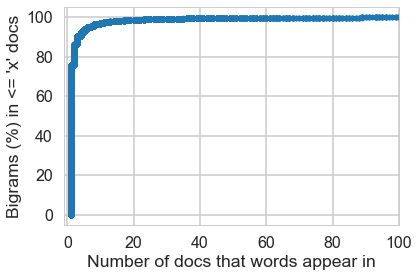

In [32]:
# lets draw cumulative density function
x = np.sort(bigram_df["NumOfDocs"])
y= np.arange(1,len(x)+1)*100/len(x)
plt.plot(x,y,marker='.',linestyle='none')
plt.xlim(-1,100)
plt.xlabel("Number of docs that words appear in")
plt.ylabel("Bigrams (%) in <= 'x' docs")
plt.show()

In [33]:
def find_best_params(vctrzr, mnb):
    #the grid of parameters to search over
    alphas = [1,5,10,50]
    ngrm_min_df = [0,0.00001,0.0001,0.001,0.003,0.005,0.01]
    best_min_df = None

    #Find the best value for alpha and min_df, and the best classifier
    best_alpha = None
    maxscore=-np.inf
    for alpha in alphas:
        for min_df in min_dfs:
            vctrzr.min_df = min_df
            Xthis, ythis = make_xy(critics, vctrzr)
            Xtrainthis = Xthis[mask]
            ytrainthis = ythis[mask]
            mnb.alpha = alpha
            curr_score = cv_score(mnb,Xtrainthis,ytrainthis,log_likelihood)
            if maxscore <  curr_score:
                maxscore = curr_score
                best_alpha = alpha
                best_min_df = min_df
    print("best alpha: {}".format(best_alpha))
    print("best min_df: {}".format(best_min_df))
    return (best_min_df,best_alpha)

In [34]:
def find_good_bad_words(vctrzr,clfr):
    words = np.array(vctrzr.get_feature_names())

    x = np.eye(xtest.shape[1])
    probs = clfr.predict_log_proba(x)[:, 0]
    ind = np.argsort(probs)

    good_words = words[ind[:10]]
    bad_words = words[ind[-10:]]

    good_prob = probs[ind[:10]]
    bad_prob = probs[ind[-10:]]

    print("Good words\t     P(fresh | word)")
    for w, p in zip(good_words, good_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

    print("Bad words\t     P(fresh | word)")
    for w, p in zip(bad_words, bad_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

In [35]:
# Your turn
vectorizer = CountVectorizer(ngram_range=(1,2))
(best_min_df,best_alpha) = find_best_params(vectorizer, MultinomialNB())

vectorizer = CountVectorizer(min_df=best_min_df,ngram_range=(1,2))
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

best alpha: 10
best min_df: 0.003
Accuracy on training data: 0.736774
Accuracy on test data:     0.679673


In [36]:
find_good_bad_words(vectorizer,clf)

Good words	     P(fresh | word)
        entertaining 0.82
              one of 0.82
            the most 0.80
         intelligent 0.80
         performance 0.80
                ever 0.79
            the best 0.79
            american 0.78
            powerful 0.78
               smart 0.78
Bad words	     P(fresh | word)
               fails 0.37
             obvious 0.37
               lacks 0.37
                  tv 0.37
               worst 0.36
               feels 0.36
                dull 0.34
               video 0.34
                 bad 0.34
       unfortunately 0.32


<div class="alert alert-success">
Random Forest classifier
</div>

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

rf = RandomForestClassifier()

parameters = {
 'max_depth': [10, 20, 30, 40, 50],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 20, 50, 100]
}

fitmodel = GridSearchCV(rf, param_grid=parameters, scoring="accuracy")

fitmodel.fit(xtrain,ytrain)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [10, 20, 30, 40, 50], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [38]:
#your turn. Print the accuracy on the test and training dataset
training_accuracy = fitmodel.best_estimator_.score(xtrain, ytrain)
test_accuracy = fitmodel.best_estimator_.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.896123
Accuracy on test data:     0.669666


<div class="alert alert-success">
Latent Dirichlet Allocation

<p>
<p>
We will perform the following steps:
<p>
Tokenization- Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
Words that have fewer than 3 characters are removed.
<p>
All stopwords are removed.
<p>
Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
<p>
Words are stemmed — words are reduced to their root form.
</div>

In [39]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import PorterStemmer
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nehajain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [40]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [41]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [42]:
doc_sample = critics.quote[10]
print('original document: ')
print(doc_sample)

print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
How perfect that two of the most popular funny guys around, Tom Hanks and Tim Allen, speak for the lead boy-toys.


 tokenized and lemmatized document: 
['perfect', 'popular', 'funni', 'guy', 'hank', 'allen', 'speak', 'lead', 'toy']


In [85]:
processed_docs = critics.quote.map(preprocess)
processed_docs[:10]

1     [ingeni, concept, design, execut, watch, posta...
2                                [year, invent, comedi]
3                         [win, anim, featur, spectrum]
4     [film, sport, provoc, appeal, stori, equal, te...
5     [entertain, gener, hyperrealist, anim, featur,...
6     [lion, king, stori, reviv, american, children,...
7     [film, probabl, fulli, appreci, adult, love, s...
8     [children, enjoy, irresist, idea, toy, come, l...
9     [gener, imageri, impress, major, surpris, brig...
10    [perfect, popular, funni, guy, hank, allen, sp...
Name: quote, dtype: object

In [86]:
processed_docs.size

15561

In [65]:
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary

In [83]:
len(dictionary.keys())

1875

In [45]:
{key:dictionary.get(key) for key in dictionary.keys()[0:10]}

{0: 'charm',
 1: 'concept',
 2: 'design',
 3: 'engulf',
 4: 'execut',
 5: 'ingeni',
 6: 'postag',
 7: 'screen',
 8: 'size',
 9: 'stamp'}

In [77]:
dictionary.filter_extremes(no_below=15, no_above=0.5)

In [78]:
#to remove movie and film words
dictionary.filter_n_most_frequent(2)

In [79]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [80]:
bow_corpus[2]

[(11, 1), (12, 1), (13, 1)]

In [81]:
lda_model = gensim.models.LdaModel(bow_corpus, num_topics=10, id2word=dictionary, passes=2)

In [95]:
[lda_model.print_topic(i) for i in range(1,10)]

['0.018*"anim" + 0.018*"music" + 0.016*"like" + 0.015*"think" + 0.013*"great" + 0.012*"know" + 0.011*"best" + 0.011*"peopl" + 0.010*"effort" + 0.010*"charact"',
 '0.027*"effect" + 0.013*"action" + 0.013*"gener" + 0.012*"special" + 0.011*"comedi" + 0.010*"laugh" + 0.009*"fall" + 0.008*"high" + 0.008*"teen" + 0.008*"spirit"',
 '0.028*"time" + 0.015*"mean" + 0.014*"end" + 0.013*"best" + 0.011*"perform" + 0.010*"like" + 0.010*"especi" + 0.009*"right" + 0.009*"long" + 0.009*"brilliant"',
 '0.020*"director" + 0.015*"screen" + 0.014*"hour" + 0.012*"see" + 0.010*"like" + 0.010*"stuff" + 0.009*"half" + 0.009*"minut" + 0.009*"narr" + 0.008*"good"',
 '0.028*"direct" + 0.020*"littl" + 0.018*"play" + 0.015*"stori" + 0.015*"enjoy" + 0.015*"write" + 0.013*"act" + 0.013*"plot" + 0.011*"talent" + 0.010*"script"',
 '0.033*"comedi" + 0.031*"funni" + 0.015*"romant" + 0.015*"entertain" + 0.014*"best" + 0.012*"sens" + 0.011*"year" + 0.011*"delight" + 0.011*"like" + 0.010*"look"',
 '0.012*"lose" + 0.010*"sto

In [89]:
lda_model.num_terms

1875

In [90]:
len(bow_corpus)

15561

In [100]:
lda_model.get_document_topics(bow_corpus[10])

[(0, 0.02500105),
 (1, 0.025000814),
 (2, 0.024999997),
 (3, 0.7749653),
 (4, 0.025001315),
 (5, 0.025002576),
 (6, 0.025003277),
 (7, 0.025000444),
 (8, 0.025019342),
 (9, 0.025005814)]

In [99]:
processed_docs[10]

['perfect', 'popular', 'funni', 'guy', 'hank', 'allen', 'speak', 'lead', 'toy']

In [109]:
x = [[topic[1] for topic in lda_model.get_document_topics(item)] for item in bow_corpus]

In [117]:
topic_df = pd.DataFrame(x)

In [120]:
topic_df.head(11)

,0,1,2,3,4,5,6,7,8,9
0,0.011120,0.011113,0.122975,0.011113,0.124875,0.011118,0.482457,0.203004,0.011112,0.011113
1,0.025000,0.025004,0.025003,0.025002,0.025001,0.025001,0.537124,0.025001,0.262862,0.025001
2,0.025000,0.524310,0.025004,0.025000,0.025001,0.025000,0.275683,0.025000,0.025001,0.025001
3,0.012501,0.145110,0.266140,0.012501,0.012500,0.261387,0.128962,0.012502,0.135890,0.012506
4,0.016668,0.353377,0.513280,0.016667,0.016667,0.016667,0.016670,0.016667,0.016668,0.016668
5,0.119612,0.813710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.935704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.083645,0.238302,0.624191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.750360,0.131053,0.064729,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.011111,0.011113,0.011115,0.011114,0.233455,0.011112,0.210651,0.261993,0.227224,0.011112


In [123]:
topic_df.shape

(15561, 10)

In [174]:
topic_df = topic_df.fillna(0)

In [184]:
vectorizer_lda = CountVectorizer(min_df=0.001) 

X, y = make_xy(critics, vectorizer_lda)

In [197]:
X_df = pd.DataFrame(X.todense())
X_df.index,topic_df.index
topic_df.columns = ["topic"+str(i) for i in range(1,11)]

In [200]:
# join topic features with bag of words features
X = X_df.join(topic_df)

In [201]:
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_train.shape, y_train.shape

((11670, 2130), (11670,))

In [202]:
y_train

array([0, 1, 1, ..., 1, 1, 1])

In [203]:
y_train.shape

(11670,)

In [204]:
lda_mnb = MultinomialNB(alpha=5)

In [205]:
lda_mnb.fit(X_train,y_train)

MultinomialNB(alpha=5, class_prior=None, fit_prior=True)

In [207]:
#y_pred = lda_mnb.predict(X_test)
print("train accuracy: {}".format(lda_mnb.score(X_train,y_train)))
print("train accuracy: {}".format(lda_mnb.score(X_test,y_test)))


train accuracy: 0.7914310197086547
train accuracy: 0.7381135954767412


<div class="alert alert-success">
Using TF-IDF weighting instead of word counts
</div>

In [14]:
critics_df.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"so ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,the year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,a winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,the film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"an entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [17]:
tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word',)
txt_fitted = tf.fit(critics.quote)
txt_transformed = txt_fitted.transform(critics.quote)


/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [18]:
tf.vocabulary_

{'so': 18252,
 'ingenious': 10176,
 'in': 9950,
 'concept': 4003,
 'design': 5251,
 'and': 891,
 'execution': 6856,
 'that': 19914,
 'you': 22330,
 'could': 4386,
 'watch': 21732,
 'it': 10555,
 'on': 13657,
 'postage': 14940,
 'stamp': 18757,
 'sized': 17943,
 'screen': 17231,
 'still': 18904,
 'be': 1767,
 'engulfed': 6494,
 'by': 2784,
 'its': 10566,
 'charm': 3248,
 'the': 19917,
 'year': 22292,
 'most': 12878,
 'inventive': 10463,
 'comedy': 3835,
 'winning': 22051,
 'animated': 939,
 'feature': 7249,
 'has': 9055,
 'something': 18347,
 'for': 7729,
 'everyone': 6758,
 'age': 595,
 'spectrum': 18505,
 'film': 7395,
 'sports': 18626,
 'provocative': 15409,
 'appealing': 1049,
 'story': 18970,
 'every': 6754,
 'bit': 2074,
 'equal': 6617,
 'of': 13584,
 'this': 19995,
 'technical': 19760,
 'achievement': 374,
 'an': 863,
 'entertaining': 6556,
 'computer': 3983,
 'generated': 8229,
 'hyperrealist': 9694,
 'animation': 942,
 '1995': 139,
 'also': 757,
 'effect': 6211,
 'toy': 20337,


In [19]:
X = txt_transformed.todense()
y = (critics.fresh == 'fresh').values.astype(np.int)

In [20]:
X.shape

(15561, 22417)

In [21]:
X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [23]:
X_train.shape, y_train.shape

((10892, 22417), (10892,))

In [24]:
mnb_tfidf = MultinomialNB(alpha=5)

In [25]:
mnb_tfidf.fit(X_train,y_train)

MultinomialNB(alpha=5, class_prior=None, fit_prior=True)

In [26]:
mnb_tfidf.score(X_test,y_test)

0.7603341186549583

In [27]:
mnb_tfidf.score(X_train,y_train)

0.945280940139552